In [1]:
"""
@Description: CNN_AE
@Author: Dezhan Tu
@LastEditTime: 08/23/2020
"""

import numpy as np
import os

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import matplotlib.pyplot as plt


# Define hyperparameters
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 128

In [10]:
# Data utility

# Convert data to torch.FloatTensor
img_transform  = transforms.Compose([transforms.ToTensor()])

# Download MNIST Dataset
train_dataset = MNIST(
    root="./dataset", 
    train=True, 
    transform=img_transform, 
    download=True
)

test_dataset = MNIST(
    root="./dataset", 
    train=False, 
    transform=img_transform, 
    download=True
)

# Create training and testing datasets
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False
)


def save_epoch_img(img, epoch):
    """
    save img during training process
    """
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './CNN_AE_Result/CNN_AE_Result{}.png'.format(epoch))


def make_dir():
    """
    make directory to store result
    """
    if not os.path.exists('CNN_AE_Result'):
        os.makedirs('CNN_AE_Result')
        
make_dir()    #Create result directory

In [11]:
class CNNAE(nn.Module):
    """
    CNNAE Class
    """
    def __init__(self):
        """
        define network structure
        """
        super(CNNAE, self).__init__()
        
        #Encoder
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)
        
        
    
    def forward(self, x):
        """
        forward computing
        """

        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        
        x = torch.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x

# Training Process

In [14]:
# Use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate an CNN-AE
model = CNNAE().to(device)

# Mean-Squared Error Loss
criterion = nn.MSELoss()

# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training Process
loss_output = []

for epoch in range(NUM_EPOCHS):
    loss = 0.0  
    for img, _ in train_loader:
        img = img.to(device)    # Reshape mini-batch data
        optimizer.zero_grad()                 # Reset the gradients back to zero
        outputs = model(img)                  # Reconstruction
        train_loss = criterion(outputs, img)  # Reconstruction loss
        train_loss.backward()                 # Compute accumulated gradients
        optimizer.step()                      # Parameters update
        loss += train_loss.item()             # Add the mini-batch training loss to epoch loss
    
    
    loss = loss / len(train_loader)           # Compute the epoch training loss
    loss_output.append(loss)
    
    # Display the epoch training loss
    print("Epoch : {}/{}, Training loss = {:.3f}".
          format(epoch + 1, NUM_EPOCHS, loss))
    
    # Save result
    if epoch % 10 == 0:
        save_epoch_img(outputs.cpu().data, epoch)

Epoch : 1/20, Training loss = 0.076
Epoch : 2/20, Training loss = 0.021
Epoch : 3/20, Training loss = 0.017
Epoch : 4/20, Training loss = 0.016
Epoch : 5/20, Training loss = 0.015
Epoch : 6/20, Training loss = 0.014
Epoch : 7/20, Training loss = 0.013
Epoch : 8/20, Training loss = 0.013
Epoch : 9/20, Training loss = 0.013
Epoch : 10/20, Training loss = 0.012
Epoch : 11/20, Training loss = 0.012
Epoch : 12/20, Training loss = 0.011
Epoch : 13/20, Training loss = 0.010
Epoch : 14/20, Training loss = 0.010
Epoch : 15/20, Training loss = 0.010
Epoch : 16/20, Training loss = 0.009
Epoch : 17/20, Training loss = 0.009
Epoch : 18/20, Training loss = 0.009
Epoch : 19/20, Training loss = 0.009
Epoch : 20/20, Training loss = 0.009


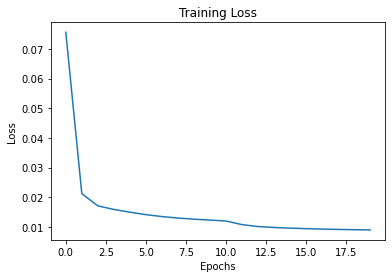

In [15]:
# Visulize the loss 
plt.figure()
plt.plot(loss_output)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('./CNN_AE_Result/CNN_AE_Train_Loss.png')

# Testing Process

In [16]:
#Testing Process
i = 0
for img, _ in test_loader:
    img = img.to(device)                  # Reshape mini-batch data
    outputs = model(img)                  # Reconstruction
    outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    
    i = i + 1 
    save_image(outputs, './CNN_AE_Result/test_result_{}.png'.format(i))